#**Telegram: @vsemalo (https://t.me/vsemalo).**
#**All models and the original code provided by @smlkw (https://t.me/smlkw).**
# Transcribing Ukrainian Video with wav2vec2, BERT, and Yodas2

## Overview
This notebook demonstrates how to transcribe Ukrainian video content using state-of-the-art technologies:
- **wav2vec2**: For extracting features from audio.
- **BERT**: For enhancing language understanding and processing.
- **Yodas2**: For transcribing the audio into text.

The workflow includes downloading the video, extracting audio, processing it, and then transcribing the text.

## Steps
1. **Download and Convert Video**: Obtain video and extract audio.
2. **Audio Processing**: Use wav2vec2 to process the audio.
3. **Transcription**: Leverage Yodas2 and BERT for accurate transcription.

## A generic pipeline to understand the principles:

Install dependencies:

In [ ]:
%%capture
!pip install -U soundfile transformers torch yt-dlp git+https://github.com/egorsmkv/whisperX.git git+https://github.com/egorsmkv/faster-whisper
!apt install -y zstd

Model parameters:

In [ ]:
model_name_url = {
    "checkpoint-66000.tar.zst": "https://www.dropbox.com/scl/fi/xha4knkapfjweo568ntmu/checkpoint-66000.tar.zst?rlkey=sgynt715zi4jxwoxfg0t8hssu&st=2xvttaaf&dl=0",
    "checkpoint-126000.tar.zst": "https://www.dropbox.com/scl/fi/i00l8v0mf5f42d38ysz7r/checkpoint-126000.tar.zst?rlkey=sb6aanvil09iyym88z77266v8&st=ab91io7w&dl=0",
    "checkpoint-199986.tar.zst": "https://www.dropbox.com/scl/fi/vojxfd7b5f4wlli2w6od4/checkpoint-199986.tar.zst?rlkey=bqriqse2ld0r27ek3r3kbt83z&st=z0tqjh11&dl=0",
}

In [ ]:
selected_model = "checkpoint-199986.tar.zst"

Download the model:

In [ ]:
!wget -O {selected_model} {model_name_url[selected_model]}
!tar --use-compress-program "zstd -d" -xf {selected_model}

--2024-08-08 12:50:20--  https://www.dropbox.com/scl/fi/vojxfd7b5f4wlli2w6od4/checkpoint-199986.tar.zst?rlkey=bqriqse2ld0r27ek3r3kbt83z
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc71eab9384819c6b309f5092ffc.dl.dropboxusercontent.com/cd/0/inline/CYMJsUiQig8mPRBX8x9T6Gwb7z4--qcnyF6FFuinbtVE186zYhnI1BquPQIkhxtvJTGESimD8WIufikHriYrnBrHBb_gUxIZeWXONhD39yg8h1MDO_Xyyt48tCNzH3AV8Lp0DSvTnR69-uqo9zIjbM_B/file# [following]
--2024-08-08 12:50:21--  https://uc71eab9384819c6b309f5092ffc.dl.dropboxusercontent.com/cd/0/inline/CYMJsUiQig8mPRBX8x9T6Gwb7z4--qcnyF6FFuinbtVE186zYhnI1BquPQIkhxtvJTGESimD8WIufikHriYrnBrHBb_gUxIZeWXONhD39yg8h1MDO_Xyyt48tCNzH3AV8Lp0DSvTnR69-uqo9zIjbM_B/file
Resolving uc71eab9384819c6b309f5092ffc.dl.dropboxusercontent.com (uc71eab9384819c6b309f5092ffc.dl.dropboxusercontent.com)... 162.1

Configure:

In [ ]:
from torch.cuda import is_available as cuda_is_available


sampling_rate = 16_000
device = "cuda:0" if cuda_is_available() else "cpu"
filename = "stt_video.wav"
model_name = selected_model.removesuffix(".tar.zst")

Load the VAD model:

In [ ]:
from whisperx.vad import load_vad_model


vad_options = {
  "vad_onset": .5,
  "vad_offset": .363,
}

vad_chunk_size = 10  # default: 30
vad_model = load_vad_model(device, use_auth_token=None, **vad_options)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.1+cu121. Bad things might happen unless you revert torch to 1.x.


Load the wav2vec2-bert model:

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2BertProcessor


asr_model = AutoModelForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2BertProcessor.from_pretrained(model_name)

## Piece-by-piece demonstration:

Example video:

In [ ]:
video_url = "https://youtu.be/piLkMXDNPqo?si=l52MBLiUJ_7br2Pn"

Download a WAV file:

In [ ]:
%%capture
!yt-dlp --extract-audio --audio-format wav -o {filename} {video_url} --force-overwrites
!ffmpeg -i {filename} -ar {sampling_rate} -ac 1 converted_{filename} -y

Information about a WAV file:

In [ ]:
!ffprobe converted_{filename}

ffprobe version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2007-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --ena

Split the audio file to chunks by the VAD model:

In [ ]:
from whisperx.audio import load_audio
from whisperx.vad import merge_chunks
from torch import from_numpy


audio = load_audio(filename)
vad_chunks = vad_model(
    {"waveform": from_numpy(audio).unsqueeze(0), "sample_rate": sampling_rate}
)

vad_segments = merge_chunks(
    vad_chunks,
    vad_chunk_size,
    onset=vad_options["vad_onset"],
    offset=vad_options["vad_offset"],
)

print(f"{vad_segments=}")
print(f"VAD chunks: {len(vad_segments)}")

vad_segments=[{'start': 6.646757679180888, 'end': 7.8583617747440275, 'segments': [(6.646757679180888, 7.8583617747440275)]}, {'start': 11.322525597269625, 'end': 18.57508532423208, 'segments': [(11.322525597269625, 18.57508532423208)]}, {'start': 19.820819112627987, 'end': 23.370307167235495, 'segments': [(19.820819112627987, 23.370307167235495)]}, {'start': 26.100682593856657, 'end': 34.29180887372014, 'segments': [(26.100682593856657, 34.29180887372014)]}, {'start': 40.503412969283275, 'end': 50.1962457337884, 'segments': [(40.503412969283275, 50.1962457337884)]}, {'start': 56.30546075085324, 'end': 60.65699658703072, 'segments': [(56.30546075085324, 60.65699658703072)]}, {'start': 61.78327645051195, 'end': 66.69795221843005, 'segments': [(61.78327645051195, 66.69795221843005)]}, {'start': 66.98805460750854, 'end': 73.67747440273038, 'segments': [(66.98805460750854, 73.67747440273038)]}, {'start': 74.41126279863482, 'end': 84.00170648464164, 'segments': [(74.41126279863482, 78.98464

Transcribe the audio:

In [ ]:
from time import time, gmtime, strftime
from pyannote.core import Segment
from pyannote.audio.core.io import Audio as PyAnnoteAudio
from soundfile import read
from torch import tensor, argmax, inference_mode
from torchaudio import save


t0 = time()

audio = PyAnnoteAudio(sample_rate=sampling_rate, mono="downmix")

transcriptions = []
for idx, segment in enumerate(vad_segments):
    segment_speech = Segment(start=segment["start"], end=segment["end"])

    ts_start = strftime("%M:%S", gmtime(segment_speech.start))
    ts_end = strftime("%M:%S", gmtime(segment_speech.end))
    sec = round(segment_speech.end - segment_speech.start, 2)

    chunk, _ = audio.crop({"audio": filename}, segment_speech, mode="pad")
    segment_filename = f"segment_{idx}.wav"

    save(segment_filename, chunk, sample_rate=sampling_rate)

    audio_input, _ = read(segment_filename)

    inputs = processor([audio_input], sampling_rate=sampling_rate).input_features
    features = tensor(inputs).to(device)

    with inference_mode():
        logits = asr_model(features).logits

    predicted_ids = argmax(logits, dim=-1)
    predictions = processor.batch_decode(predicted_ids)

    transcriptions.append(
        {
            "idx": idx,
            "segment_filename": segment_filename,
            "text": predictions[0],
            "ts_start": ts_start,
            "ts_end": ts_end,
            "sec": sec,
        }
    )

elapsed_time = time() - t0
total_audio_duration = sum([row["sec"] for row in transcriptions])
rtf = elapsed_time / total_audio_duration

print(f"Elapsed: {elapsed_time:,.4f} seconds")
print(f"Total audio duration: {total_audio_duration} seconds")
print(f"Real-Time Factor (RTF): {rtf:,.4f}")

Elapsed: 41.7177 seconds
Total audio duration: 430.2500000000001 seconds
Real-Time Factor (RTF): 0.0970


Render audios and their transcriptions:

In [ ]:
from IPython.display import Audio


for row in transcriptions[:5]:
    print(f'{row["idx"]}: {row["ts_start"]} - {row["ts_end"]}, seconds: {row["sec"]}')
    load_audio(row["segment_filename"])
    display(Audio(row["segment_filename"]))
    print(row["text"], end="\n\n")

0: 00:06 - 00:07, seconds: 1.21


язика та хвейська

1: 00:11 - 00:18, seconds: 7.25


немає гіршого того чоловіка що не вміє зка за зубами вдежити а найбільше лихо жінками

2: 00:19 - 00:23, seconds: 3.55


тільки що почує зараз уже й роздзвонила по всьому селу

3: 00:26 - 00:34, seconds: 8.19


ой кумайсюріднесенька що я чула та тільки глядіть нікому не кажіть бо це таке що нікомусь знати не можна я це тільки вам

4: 00:40 - 00:50, seconds: 9.69


і почала а кума почула та другій кумі а та третій а третя п'ятій десятій і отоже всі протизнають чого не треба нікому знати



## General demo (API):

In [ ]:
from subprocess import run, CalledProcessError
from os.path import exists
from time import time


class TranscriptionAPI:
    def __init__(
        self,
        vad_model_pretrained,
        device="cuda:0" if cuda_is_available() else "cpu",
        sampling_rate=16_000,
        vad_chunk_size=10,
    ):
        self.vad_model_pretrained = vad_model_pretrained
        self.device = device
        self.sampling_rate = sampling_rate
        self.vad_chunk_size = vad_chunk_size

    def transcribe_video_from_url(
        self,
        url,
        vad_options,
        processor,
        asr_model,
        filename="stt_video.wav",
    ):
        """
        Transcribes audio from a video URL using a pretrained VAD model.

        Parameters:
            url (str): The URL of the video to transcribe.
            filename (str): The filename to save the converted audio. Default is "stt_video.wav".
            vad_options (dict): Options for the VAD model.
            processor (Wav2Vec2BertProcessor): The processor for the ASR model.
            asr_model (AutoModelForCTC): The ASR model.

        Returns:
            str: The complete transcribed text.
        """
        start_time = time()

        print("Starting audio download and conversion...")
        download_start_time = time()
        self._download_and_convert_audio(
            url, output_wav=filename, output_converted=f"converted_{filename}"
        )
        download_duration = time() - download_start_time
        print(f"Audio download and conversion took {download_duration:.2f} seconds")

        print("Loading audio file...")
        load_start_time = time()
        audio = load_audio(f"converted_{filename}")
        load_duration = time() - load_start_time
        print(f"Audio loading took {load_duration:.2f} seconds")

        print("Processing audio with VAD model...")
        vad_start_time = time()
        vad_chunks = self.vad_model_pretrained(
            {
                "waveform": from_numpy(audio).unsqueeze(0),
                "sample_rate": self.sampling_rate,
            }
        )
        vad_segments = merge_chunks(
            vad_chunks,
            self.vad_chunk_size,
            onset=vad_options.get("vad_onset", 0),
            offset=vad_options.get("vad_offset", 0),
        )
        vad_duration = time() - vad_start_time
        print(f"VAD processing took {vad_duration:.2f} seconds")

        print("Transcribing audio segments...")
        transcribe_start_time = time()
        transcriptions = []
        for idx, segment in enumerate(vad_segments):
            transcription = self._process_segment(
                segment, idx, f"converted_{filename}", processor, asr_model
            )
            transcriptions.append(transcription)
        transcribe_duration = time() - transcribe_start_time
        print(f"Transcription took {transcribe_duration:.2f} seconds")

        total_duration = time() - start_time
        print(f"Total transcription process took {total_duration:.2f} seconds")

        return " ".join(transcriptions)

    def transcribe_video_from_file(
        self,
        file_path,
        vad_options,
        processor,
        asr_model,
        filename="stt_video.wav",
    ):
        """
        Transcribes audio from a video file using a pretrained VAD model.

        Parameters:
            file_path (str): The path to the video file to transcribe.
            filename (str): The filename to save the converted audio. Default is "stt_video.wav".
            vad_options (dict): Options for the VAD model.
            processor (Wav2Vec2BertProcessor): The processor for the ASR model.
            asr_model (AutoModelForCTC): The ASR model.

        Returns:
            str: The complete transcribed text.
        """
        start_time = time()

        print("Starting audio conversion...")
        convert_start_time = time()
        self._convert_audio_from_file(
            file_path, output_wav=filename, output_converted=f"converted_{filename}"
        )
        convert_duration = time() - convert_start_time
        print(f"Audio conversion took {convert_duration:.2f} seconds")

        print("Loading audio file...")
        load_start_time = time()
        audio = load_audio(f"converted_{filename}")
        load_duration = time() - load_start_time
        print(f"Audio loading took {load_duration:.2f} seconds")

        print("Processing audio with VAD model...")
        vad_start_time = time()
        vad_chunks = self.vad_model_pretrained(
            {
                "waveform": from_numpy(audio).unsqueeze(0),
                "sample_rate": self.sampling_rate,
            }
        )
        vad_segments = merge_chunks(
            vad_chunks,
            self.vad_chunk_size,
            onset=vad_options.get("vad_onset", 0),
            offset=vad_options.get("vad_offset", 0),
        )
        vad_duration = time() - vad_start_time
        print(f"VAD processing took {vad_duration:.2f} seconds")

        print("Transcribing audio segments...")
        transcribe_start_time = time()
        transcriptions = []
        for idx, segment in enumerate(vad_segments):
            transcription = self._process_segment(
                segment, idx, f"converted_{filename}", processor, asr_model
            )
            transcriptions.append(transcription)
        transcribe_duration = time() - transcribe_start_time
        print(f"Transcription took {transcribe_duration:.2f} seconds")

        total_duration = time() - start_time
        print(f"Total transcription process took {total_duration:.2f} seconds")

        return " ".join(transcriptions)

    def _process_segment(self, segment, idx, filename, processor, asr_model):
        """
        Processes a single audio segment and returns the transcription.

        Parameters:
            segment (dict): The VAD segment with start and end times.
            idx (int): The index of the segment.
            filename (str): The path to the audio file.
            processor (Wav2Vec2BertProcessor): The processor for the ASR model.
            asr_model (AutoModelForCTC): The ASR model.

        Returns:
            str: The transcribed text.
        """
        segment_speech = Segment(start=segment["start"], end=segment["end"])
        chunk, _ = PyAnnoteAudio(sample_rate=self.sampling_rate, mono="downmix").crop(
            {"audio": filename}, segment_speech, mode="pad"
        )
        segment_filename = f"segment_{idx}.wav"
        save(segment_filename, chunk, sample_rate=self.sampling_rate)
        audio_input, _ = read(segment_filename)

        inputs = processor(
            [audio_input], sampling_rate=self.sampling_rate
        ).input_features
        features = tensor(inputs).to(self.device)

        with inference_mode():
            logits = asr_model(features).logits

        predicted_ids = argmax(logits, dim=-1)
        predictions = processor.batch_decode(predicted_ids)

        return predictions[0]

    def _download_and_convert_audio(self, url, output_wav, output_converted):
        try:
            download_command = [
                "yt-dlp",
                "--extract-audio",
                "--audio-format",
                "wav",
                "-o",
                output_wav,
                url,
                "--force-overwrites",
            ]
            result = run(download_command, check=True)
            if result.returncode != 0:
                raise Exception("Failed to download audio.")

            if not exists(output_wav):
                raise Exception(f"Downloaded audio file not found: {output_wav}")

            print(f"Downloaded audio file: {output_wav}")

            convert_command = [
                "ffmpeg",
                "-i",
                output_wav,
                "-ar",
                str(self.sampling_rate),
                "-ac",
                "1",
                output_converted,
                "-y",
            ]
            result = run(convert_command, check=True)
            if result.returncode != 0:
                raise Exception("Failed to convert audio.")

            if not exists(output_converted):
                raise Exception(f"Converted audio file not found: {output_converted}")

            print(f"Converted audio file: {output_converted}")

        except Exception as e:
            print(f"Error during audio processing: {e}")
            raise

    def _convert_audio_from_file(self, file_path, output_wav, output_converted):
        try:
            if not exists(file_path):
                raise Exception(f"File not found: {file_path}")

            convert_command = [
                "ffmpeg",
                "-i",
                file_path,
                "-ar",
                str(self.sampling_rate),
                "-ac",
                "1",
                output_converted,
                "-y",
            ]
            result = run(convert_command, check=True)
            if result.returncode != 0:
                raise Exception("Failed to convert audio.")

            if not exists(output_converted):
                raise Exception(f"Converted audio file not found: {output_converted}")

            print(f"Converted audio file: {output_converted}")

        except CalledProcessError as e:
            print(f"CalledProcessError: {e}")
            raise
        except Exception as e:
            print(f"Error during audio conversion: {e}")
            raise

Example of usage:
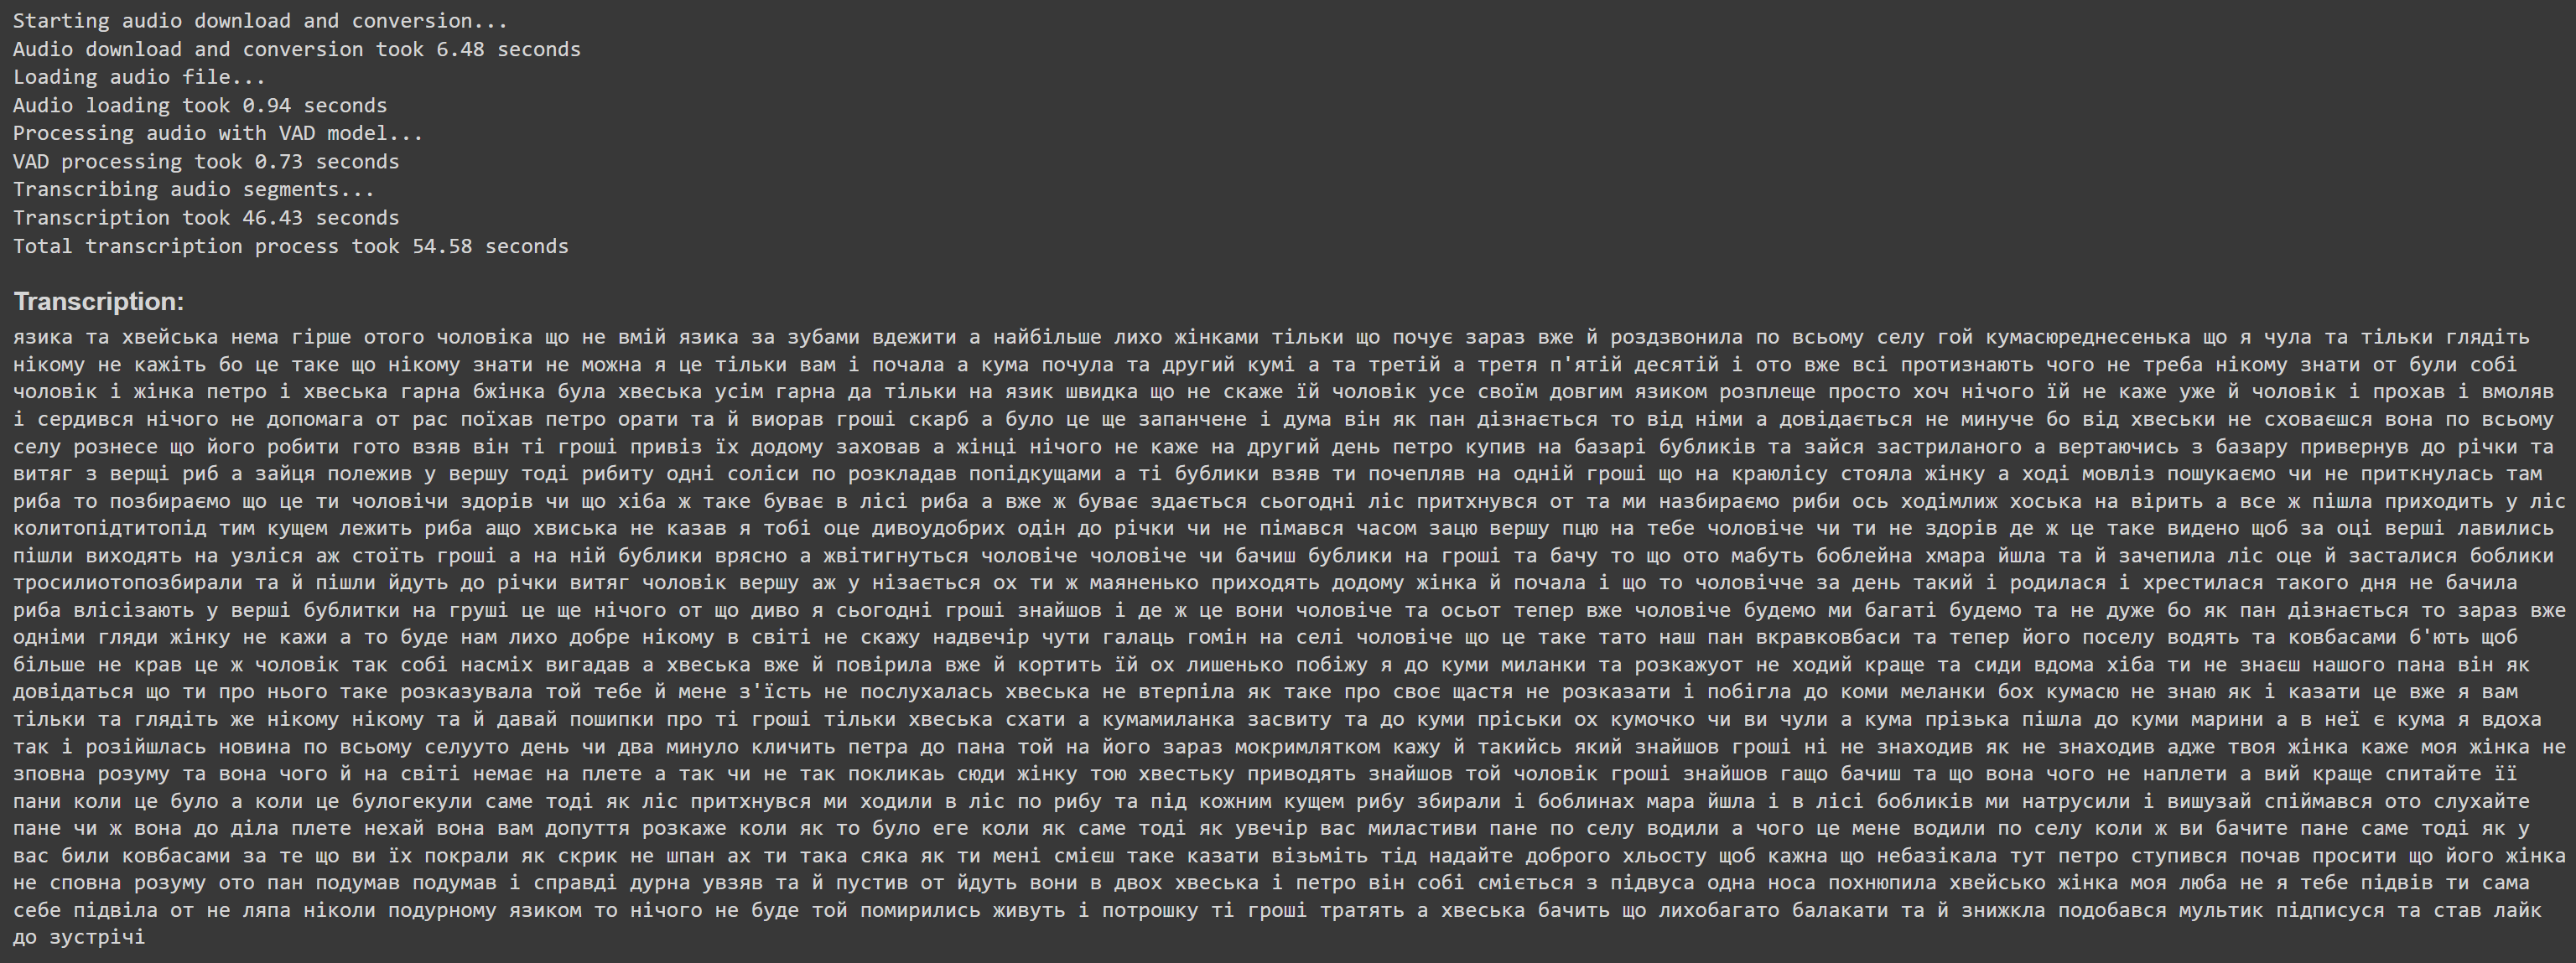

In [ ]:
from IPython.display import display, HTML


def display_transcription(transcribed_text: str):
    html_content = f"""
    <h3>Transcription:</h3>
    <pre style="white-space: pre-wrap; word-wrap: break-word;">{transcribed_text}</pre>
    """
    display(HTML(html_content))


def save_transcription_to_file(transcribed_text: str, filename: str):
    with open(filename, "w") as file:
        file.write(transcribed_text)


def main():
    api = TranscriptionAPI(vad_model_pretrained=vad_model)
    transcribed_text = api.transcribe_video_from_url(
        video_url, vad_options, processor, asr_model
    )

    display_transcription(transcribed_text)
    save_transcription_to_file(transcribed_text, "transcription_result.txt")


if __name__ == "__main__":
    main()

Starting audio download and conversion...
Downloaded audio file: stt_video.wav
Converted audio file: converted_stt_video.wav
Audio download and conversion took 7.63 seconds
Loading audio file...
Audio loading took 0.28 seconds
Processing audio with VAD model...
VAD processing took 0.79 seconds
Transcribing audio segments...
Transcription took 14.89 seconds
Total transcription process took 23.59 seconds
